# Image Classifier Module

ArdavanBidgoli <br />
CMU School of Architecture <br />
Robotic Plastering Project <br />
Feedback-loop image classifier <br />
Tested with/for: <br />
Tensorflow 0.12.1 <br />
OpenCV 3.2.0-dev <br />
this code has been inspired by:
https://codelabs.developers.google.com/codelabs/tensorflow-for-poets/index.html?index=../../index#4

## Imports

In [1]:
# Import Tensorflow
import tensorflow as tf
# Importing matplotlib and Numpy for image processing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import libraries for:
# System read and write, Checking object types, Time keeping
import sys
import time
from shutil import copyfile

# import os.path methods for file manipulation on the drive
import os
from os import listdir
from os.path import isfile, join, exists

# import json for json formatting
import json

## General Variables

In [2]:
# rate treshhold
rateThreshold = 0.8
# print in-progress report
printSwitch = True
# Sets the naming standard
sampleFolder = "test"
resultsFolder= "results"
# Set log file info
logFolder = "log"
logFileName = "log.txt"
failedSamplePath = "fails"

retrainedLabels = "retrained_labels.txt"
retrainedGraph = "retrained_graph.pb"

# Error messages:
nameFinderError= "File names cannot be read"
fileReadError = "Couldn't read files"


# Report messages:
saveToFileReport = "Data saved to the file: "

## Helper Functions

In [3]:
# no helper function for this part yet

## Classes

### The Classifier
This class gets the images in the tiles folder and based on the trained model will classify them.
In this case it will classify them as:
    unifinished
    scratches
    holes
    pass
Those which fall in categories except pass will be stored in the log folder for further inspection.
The extra inspection code has not been implemented yet.

In [4]:
class Classifier(object):
    
    def __init__(self):
        # keep track of time
        self.start_time = time.time()
        # basic setup
        self.logFolder = logFolder
        self.sampleFolder= sampleFolder
        self.logFolder = logFolder 
        self.logFileName = logFileName
        self.retrainedLabels = retrainedLabels
        self.retrainedGraph = retrainedGraph
        self.failedSamplePath = failedSamplePath
        self.rateThreshold = rateThreshold
        
        
        # placeholders
        self.samples = []
        self.sampleNames = []
        self.labels = []
        self.rates = []
        self.log = []
        self.fails =  dict()
        
        # initiating the instance
        Classifier.loadSamples(self)
        Classifier.nameFinder(self)
        Classifier.classifying(self)
        #Classifier.fileLogger(self)
        
        pass
    
    def nameFinder(self, folder=None):
        if folder == None : folder = self.sampleFolder
        if (not Classifier.folderCheck(self,folder)):
            return    
        # filters only the .jpg files from the folder
        try:
            files = [f for f in listdir(folder) if isfile(join(folder, f))]
            self.sampleNames = [f for f in files if f.split(".")[1] == "jpg"]
            if len(self.sampleNames == 0) : return False
        except:
            print (nameFinderError)

    # Reads the sample files
    def loadSamples(self, folder = None):
        if folder == None : folder = self.sampleFolder
        if (not Classifier.folderCheck(self,folder)):
            return    
        
        # Loads files at ./tests folder to test based on the trained model 
        # only lists the .jpg files
        # collects all file names
        try:
            files = [f for f in listdir(folder) if isfile(join(folder, f))]
            # filters only the .jpg files
            images = [f for f in files if f.split(".")[1] == "jpg"]
            size = len(images)
            for img in images:
                newPath = folder+"/"+img
                newSample = tf.gfile.FastGFile(newPath, 'rb').read()
                self.samples.append(newSample)
        except:
            print (fileReadError)
            
    # Classifies the images
    def classifying(self,sampleData = None, sampleNames= None):
        if sampleData == None : sampleData = self.samples
        if sampleNames == None : sampleNames = self.sampleNames    
        if (len(sampleData) < 1  or
            len(sampleNames) < 1 or
            sampleData == None   or
            sampleNames == None):
            #print (len(sampleData))
            #print (len(sampleNames))
            #print ("failed")
            return False    
        
        
        size = len(sampleData)
        # Loads label file, strips off carriage return
        label_lines = [line.rstrip() for line 
                       in tf.gfile.GFile(self.retrainedLabels)]
        # Unpersists graph from file
        with tf.gfile.FastGFile(self.retrainedGraph, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            ####################################################
            # just a hacky way to solve version discrpancies
            # if using older versions of Tensorflow,
            # remove this line!
            del(graph_def.node[1].attr["dct_method"])
            ####################################################
            _ = tf.import_graph_def(graph_def, name='')

        with tf.Session() as sess:
            # Feed the image_data as input to the graph and get first prediction
            softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')

            # iterating over iamges
            for i in range (size):
            #for image_data_item in image_data:
                predictions = sess.run(softmax_tensor, \
                         {'DecodeJpeg/contents:0': sampleData[i]})
                # Sort to show labels of first prediction in order of confidence
                top_k = predictions[0].argsort()[-len(predictions[0]):][::-1]
                human_string = label_lines[top_k[0]]
                score = predictions[0][top_k[0]]
                
                # update the scoreboard and labelboard
                self.rates.append(score)
                self.labels.append(human_string)
                # print report during the process
                #if (printSwitch):
                    #print ("smaple ID", str(i))
                    #print('%s (score = %.2f)' % (human_string, score))
                    #print('Correct answer: %s' %(sampleNames[i][:4]))
                    #print("------------------------------------")
                if (human_string != "pass" or score < rateThreshold):
                    self.fails[sampleNames[i]] = human_string

    def folderCheck(self,folder):
        if not os.path.exists(folder):
            os.makedirs(folder)
            log =  (Classifier.makingAFolder+ folder)
            TileSampler.logger(self, log)
            return False
        else:
            #print ("pass")
            return True
        
    def logger(self, message, header = None):
        timeVal = time.strftime("%H:%M:%S: ")
        if type(message) == list:
            size = len(message)
            tag = "size: #"+ str(size)+ "|"
            message.insert (0,tag)
            message = " ".join(message)
        
        if header != None:
            message = header  + message
        message = timeVal + message
        self.log.append(message)
    
    # Generates the log in log folder 
    def fileLogger(self):
        Classifier.report(self)
        Classifier.saveToFile(self)
        Classifier.saveFailSamples(self) 
        
    # Prints a brief report during the process
    def report(self):
        finish_time = time.time()
        ellapsed_time = finish_time - self.start_time
        average_time = ellapsed_time / float(len(self.samples))
        
        # Print the final report
        print ('Total time:', str(int(ellapsed_time)))
        print ('Average time:', str(average_time)) 
        print ("------------------------------------")
        print ("Failed samples:")
        for fail in self.fails:
            print (fail,"\t",self.fails[fail])
        print("------------------------------------")
    
    def saveToFile(self):
        folder = self.logFolder
        # converts fails to json format
        jsonData = json.dumps(self.fails)

        # check if the log directory exist
        if not exists(folder):
            os.makedirs(folder)
            
        # generates the file name to save the log
        date_string = time.strftime("_%H_%M")
        newName = folder+date_string+".txt"
        print ("newName: ",newName)
        newPath = os.path.join (folder, newName)
        print ("newPath: ",newPath)
        
        # writes to file
        log = open(newPath, "w")
        log.write(str(jsonData))
        log.close()
        print (saveToFileReport,newPath)
        logData = (saveToFileReport+newPath)
        Classifier.logger(self, logData)
        
    def saveFailSamples(self):
        for fail in self.fails:
            failedSamplePath = self.sampleFolder+"/"+fail
            name= fail.split(".")
            targetPath = self.logFolder+"/"+name[0]+"_"+self.fails[fail]+".jpg"
            copyfile(failedSamplePath, targetPath)

### Test
This will run the classifier to classify images in the tiled folder and store rejected ones in the log folder.

In [5]:
%%time
classify = Classifier()

File names cannot be read
Wall time: 16.3 s


### A histogram of the rates for every sample

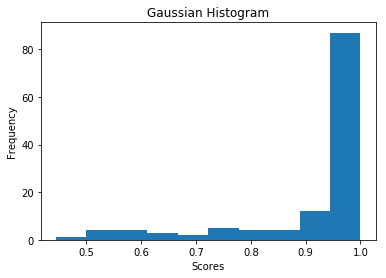

In [6]:
plt.hist(classify.rates)
plt.title("Gaussian Histogram")
plt.xlabel("Scores")
plt.ylabel("Frequency")
fig = plt.gcf()
plt.show()

### Detailed report of the rejected samples

In [7]:
for i in range (len(classify.labels)):
    print (i, "\t", classify.labels[i][1:2], "\t",classify.rates[i], "\t", classify.sampleNames[i])

0 	 0 	 0.999964 	 0_1.jpg
1 	 0 	 0.613235 	 0_11.jpg
2 	 0 	 0.913949 	 0_12.jpg
3 	 0 	 0.999941 	 0_17.jpg
4 	 0 	 0.882955 	 0_20.jpg
5 	 0 	 0.982541 	 0_22.jpg
6 	 2 	 0.505276 	 0_30.jpg
7 	 2 	 0.508427 	 0_34.jpg
8 	 0 	 0.546492 	 0_37.jpg
9 	 0 	 0.995938 	 0_39.jpg
10 	 0 	 0.996818 	 0_41.jpg
11 	 0 	 0.991986 	 0_48.jpg
12 	 2 	 0.916831 	 1_12.jpg
13 	 1 	 0.990061 	 1_15.jpg
14 	 1 	 0.885314 	 1_2.jpg
15 	 1 	 0.641522 	 1_20.jpg
16 	 1 	 0.996467 	 1_23.jpg
17 	 1 	 0.98738 	 1_24.jpg
18 	 2 	 0.971423 	 1_25.jpg
19 	 1 	 0.955003 	 1_40.jpg
20 	 1 	 0.999244 	 1_48.jpg
21 	 1 	 0.987404 	 1_54.jpg
22 	 2 	 0.676995 	 1_55.jpg
23 	 1 	 0.914244 	 1_6.jpg
24 	 2 	 0.997241 	 2_102.jpg
25 	 1 	 0.526065 	 2_106.jpg
26 	 2 	 0.908002 	 2_109.jpg
27 	 1 	 0.74778 	 2_112.jpg
28 	 2 	 0.585143 	 2_114.jpg
29 	 2 	 0.9975 	 2_126.jpg
30 	 2 	 0.936717 	 2_130.jpg
31 	 2 	 0.999677 	 2_131.jpg
32 	 2 	 0.990344 	 2_133.jpg
33 	 0 	 0.72476 	 2_135.jpg
34 	 2 	 0.575633 	 2_

In [8]:
counter = 0
for i in range (len(classify.labels)):
    if classify.labels[i][1:2] != classify.sampleNames[i][:1]:
        counter += 1
        print (i, "\t", classify.labels[i][:2], "\t", classify.sampleNames[i])
print ("Test accuracy: {}".format(1-counter/len(classify.labels)))

6 	 02 	 0_30.jpg
7 	 02 	 0_34.jpg
12 	 02 	 1_12.jpg
18 	 02 	 1_25.jpg
22 	 02 	 1_55.jpg
25 	 01 	 2_106.jpg
27 	 01 	 2_112.jpg
33 	 00 	 2_135.jpg
44 	 01 	 2_4.jpg
53 	 01 	 2_87.jpg
56 	 01 	 2_95.jpg
94 	 01 	 3_93.jpg
Test accuracy: 0.9047619047619048
